### aim: calculate co2 flux from medusa files

### date: 

- the yearly files come from makeYearlyMEDUSAsubsetfiles

In [1]:
from IPython.display import HTML

HTML('''<script>
code_show=true; 
function code_toggle() {
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>''')


In [2]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [3]:
import numpy as np
from cmocean import cm
import cartopy as cp
import cartopy.crs as ccrs
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr
import sys
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE')
#list of models
sys.path.append('/gpfs/home/mep22dku/scratch/SOZONE/UTILS')
import lom
import utils as ut

%matplotlib inline
import warnings
from datetime import datetime
warnings.filterwarnings('ignore')
import cartopy.feature as cfeature
from importlib import reload
import matplotlib.path as mpath
import glob
import pickle
import pandas as pd
import seawater
import time
plt.rcParams.update({'font.size': 12})
font = {'family' : 'normal',
'weight' : 'normal',
'size'   : 12}

plt.rc('font', **font)

In [4]:
test = False

### medusa scenario dictionary

In [5]:
scendict = {
    # Baynes Sound
    '1A': {
        'hist_str': 'bc370',
        'fut_str': 'be682',
        'name': 'HIST.OZONE \n LOW TEMP.',
        'name2':'1A: NatlOzone-SSP126',
        'color':'#E8D215',
        'color2':'orange'},
    '1B': {
        'hist_str': 'bc370',
        'fut_str': 'ce417',
        'name': 'HIST. OZONE \n HIGH TEMP.',
        'name2':'1B: NatlOzone-SSP370',
        'color':'#87800A',
        'color2':'orangered'},
    '2A': {
        'hist_str': 'cj198',
        'fut_str': 'cj880',
        'name': 'FIXED OZONE \n LOW TEMP.',
        'name2':'2A: Ozone1950-SSP126',
        'color':'#2DC18E',
        'color2':'mediumseagreen'},
    '2B': {
        'hist_str': 'cj198',
        'fut_str': 'cj881',
        'name': 'FIXED OZONE \n HIGH TEMP.',
        'name2':'2B: Ozone1950-SSP370',
        'color':'#18765C',
        'color2':'green'},
    '3A': {
        'hist_str': 'cj200',
        'fut_str': 'cj484',
        'name': '1990 OZONE \n LOW TEMP.',
        'name2':'3A: Ozone1990-SSP126',
        'color':'#FF462B',
        'color2':'dodgerblue'},
    '3B': {
        'hist_str': 'cj200',
        'fut_str': 'cj504',
        'name': '1990 OZONE \n HIGH TEMP.',
        'name2':'3B: Ozone1990-SSP370',
        'color':'#822722',
        'color2':'mediumblue'}
}

In [12]:
w = xr.open_dataset('/gpfs/home/mep22dku/scratch/SOZONE/MEDUSA/EXTRACT/medusa_1A_CFLX_PCO2_1950-2100.nc')
w

<xarray.Dataset>
Dimensions:           (month: 12, year: 150)
Coordinates:
  * year              (year) int64 1950 1951 1952 1953 ... 2096 2097 2098 2099
  * month             (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Data variables:
    mean_OCN_PCO2     (year, month) float64 ...
    mean_OCN_PCO2_SO  (year, month) float64 ...
    mean_CO2FLUX      (year, month) float64 ...
    mean_CO2FLUX_SO   (year, month) float64 ...
Attributes:
    made in:  MEDUSA/MedusaCflxPco2.ipynb

## check if files have been converted to yearly format (in makeYearlyMEDUSAsubset)

In [6]:
check = False
if check:
    scens = ['1A','1B','2A','2B','3A','3B']

    for s in range(0,6):
        tscen = scens[s]
        print()
        print(f'SCENARIO {tscen}')

        for y in range(1950,2100):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa*{tstr}*{y}*')
                ds = xr.open_dataset(td[0])
                #print(f'GOOD {tscen},{tstr}, {y}')
            except:
                print(f'FAIL {tscen},{tstr}, {y}')
                
## test to list scenario to string 
test = False
if test:
    scens = ['1A','1B','2A','2B','3A','3B']
    y = 1992
    for tscen in scens:

        print(tscen)
        y = 1989
        if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
            print('yes')
            tstr = scendict['1A']['hist_str']
        elif y<2015:
            tstr = scendict[tscen]['hist_str']

        else:
            tstr = scendict[tscen]['fut_str']

        print(tstr)

## get list of model results

In [7]:
# scens = ['1A','1B','2A','2B','3A','3B']

# def get_dslist(tscen):
#     print(f'SCENARIO {tscen}')
#     dslist = []

#     for y in range(1950,2100):
#         if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
#             tstr = scendict['1A']['hist_str']
#         elif y<2015:
#             tstr = scendict[tscen]['hist_str']

#         else:
#             tstr = scendict[tscen]['fut_str']

#         try:
#             td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa*{tstr}*{y}*')
#             dslist.append(td[0])
#         except:
#             print(f'FAIL {tscen},{tstr}, {y}')
#     return dslist

# dsl1A = get_dslist('1A')
# dsl1B = get_dslist('1B')
# dsl2A = get_dslist('2A')
# dsl2B = get_dslist('2B')
# dsl3A = get_dslist('3A')
# dsl3B = get_dslist('3B')

SCENARIO 1A
FAIL 1A,bc370, 1950
FAIL 1A,bc370, 1951
FAIL 1A,bc370, 1952
FAIL 1A,bc370, 1953
FAIL 1A,bc370, 1954
FAIL 1A,bc370, 1955
FAIL 1A,bc370, 1956
FAIL 1A,bc370, 1957
FAIL 1A,bc370, 1958
FAIL 1A,bc370, 1959
FAIL 1A,bc370, 1960
FAIL 1A,bc370, 1961
FAIL 1A,bc370, 1962
FAIL 1A,bc370, 1963
FAIL 1A,bc370, 1964
FAIL 1A,bc370, 1965
FAIL 1A,bc370, 1966
FAIL 1A,bc370, 1967
FAIL 1A,bc370, 1968
FAIL 1A,bc370, 1969
FAIL 1A,bc370, 1970
FAIL 1A,bc370, 1971
FAIL 1A,bc370, 1972
FAIL 1A,bc370, 1973
FAIL 1A,bc370, 1974
FAIL 1A,bc370, 1975
FAIL 1A,bc370, 1976
FAIL 1A,bc370, 1977
FAIL 1A,bc370, 1978
FAIL 1A,bc370, 1979
FAIL 1A,bc370, 1980
FAIL 1A,bc370, 1981
FAIL 1A,bc370, 1982
FAIL 1A,bc370, 1983
FAIL 1A,bc370, 1984
FAIL 1A,bc370, 1985
FAIL 1A,bc370, 1986
FAIL 1A,bc370, 1987
FAIL 1A,bc370, 1988
FAIL 1A,bc370, 1989
FAIL 1A,bc370, 1990
FAIL 1A,bc370, 1991
FAIL 1A,bc370, 1992
FAIL 1A,bc370, 1993
FAIL 1A,bc370, 1994
FAIL 1A,bc370, 1995
FAIL 1A,bc370, 1996
FAIL 1A,bc370, 1997
FAIL 1A,bc370, 1998
FAIL 1A,

FAIL 3A,cj200, 1995
FAIL 3A,cj200, 1996
FAIL 3A,cj200, 1997
FAIL 3A,cj200, 1998
FAIL 3A,cj200, 1999
FAIL 3A,cj200, 2000
FAIL 3A,cj200, 2001
FAIL 3A,cj200, 2002
FAIL 3A,cj200, 2003
FAIL 3A,cj200, 2004
FAIL 3A,cj200, 2005
FAIL 3A,cj200, 2006
FAIL 3A,cj200, 2007
FAIL 3A,cj200, 2008
FAIL 3A,cj200, 2009
FAIL 3A,cj200, 2010
FAIL 3A,cj200, 2011
FAIL 3A,cj200, 2012
FAIL 3A,cj200, 2013
FAIL 3A,cj200, 2014
FAIL 3A,cj484, 2015
FAIL 3A,cj484, 2016
FAIL 3A,cj484, 2017
FAIL 3A,cj484, 2018
FAIL 3A,cj484, 2019
FAIL 3A,cj484, 2020
FAIL 3A,cj484, 2021
FAIL 3A,cj484, 2022
FAIL 3A,cj484, 2023
FAIL 3A,cj484, 2024
FAIL 3A,cj484, 2025
FAIL 3A,cj484, 2026
FAIL 3A,cj484, 2027
FAIL 3A,cj484, 2028
FAIL 3A,cj484, 2029
FAIL 3A,cj484, 2030
FAIL 3A,cj484, 2031
FAIL 3A,cj484, 2032
FAIL 3A,cj484, 2033
FAIL 3A,cj484, 2034
FAIL 3A,cj484, 2035
FAIL 3A,cj484, 2036
FAIL 3A,cj484, 2037
FAIL 3A,cj484, 2038
FAIL 3A,cj484, 2039
FAIL 3A,cj484, 2040
FAIL 3A,cj484, 2041
FAIL 3A,cj484, 2042
FAIL 3A,cj484, 2043
FAIL 3A,cj484, 2044


### calculate appropriately weighted total PgC WITH XARRAY SYNTAX LIKE A HERO

In [8]:
# ##------------------create an appropriate area matrix (dimensions match dimensions of dataset we are trying to do calculations on), save it and its coordinates
# w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/diad/cj198_1950/medusa_cj198o_1m_19500401-19500501_diad-T.nc')
# area = w['area'].values
# w2 = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa_bc370_1y_1950_diad-T-subset.nc')
# nlat = w2['CO2FLUX'].nav_lat.values
# nlon =  w2['CO2FLUX'].nav_lon.values

# data_vars = {'area':(['nav_lat', 'nav_lon'], area,
# {'units': 'm2',
# 'long_name':'cell_area'})}

# coords = {'nav_lat': (nlat),
#       'nav_lon': (nlon)}
# tarea = xr.Dataset(data_vars=data_vars, coords=coords)
          
# ####load data........
# test = 10
# tds = xr.open_mfdataset(dsl1A[0:test])
# #ds_1A = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa_bc370_1y_1950_diad-T-subset.nc')

# #### weighted mean
# #print(tds['CO2FLUX']) # co2 flux, mmolC/m2/day
# co2f_w = tds['CO2FLUX'].weighted(tarea.area) # mmolC/m2/day
# co2f_w_mean = co2f_w.mean(dim = ['nav_lat', 'nav_lon']) # mmolC/m2/day (global average)
      
# #### total flux = flux/m2 * area, as timeseries
# co2f_w = tds['CO2FLUX']* (tarea.area) #mmol C/ day
# co2f_sum = co2f_w.sum(dim = ['nav_lat', 'nav_lon']) #mmol C/day, summed as timeseries at monthly interval

# # get a yearly timeseries (get yearly mean, multiply by 365, and convert units from mmolC/day to PgC/yr
# mmolC_to_PgC = 1e-18*12
# co2f_sum_yr2 = co2f_sum.groupby('time_counter.year').mean('time_counter') * 365 * mmolC_to_PgC #get yearly mean and multiply by 365 days/year
# co2f_sum_yr2.plot()


FileNotFoundError: [Errno 2] No such file or directory: b'/gpfs/data/greenocean/software/resources/MEDUSA/diad/cj198_1950/medusa_cj198o_1m_19500401-19500501_diad-T.nc'

## line plots 

In [ ]:
def get_yearly_PgC(tds_list, latmax = 332):
    
    tds = xr.open_mfdataset(tds_list)
    co2f_w = tds['CO2FLUX'][:,0:latmax,:]* (tarea.area[0:latmax,:]) #mmol C/ day
    co2f_sum = co2f_w.sum(dim = ['nav_lat', 'nav_lon']) #mmol C/day, summed as timeseries at monthly interval

    # get a yearly timeseries (get yearly mean, multiply by 365, and convert units from mmolC/day to PgC/yr
    mmolC_to_PgC = 1e-18*12
    co2f_sum_yr2 = co2f_sum.groupby('time_counter.year').mean('time_counter') #get yearly mean and multiply by 365 days/year
    co2f_sum_yr2_PgC = co2f_sum_yr2 *  365 * mmolC_to_PgC   
    co2f_sum_yr2_PgC = co2f_sum_yr2_PgC.values
    return co2f_sum_yr2_PgC

def get_yearly_pco2(tds_list, latmax = 332):
    tds = xr.open_mfdataset(tds_list)
    co2_w = tds['OCN_PCO2'].weighted(tarea.area) # mmolC/m2/day
    co2_w_mean = co2_w.mean(dim = ['nav_lat', 'nav_lon']) # mmolC/m2/day (global average)
    co2_w_mean_yr2 = co2_w_mean.groupby('time_counter.year').mean('time_counter') #get yearly mean and multiply by 365 days/year
    co2_w_mean_yr2 = co2_w_mean_yr2.values
    return co2_w_mean_yr2



In [9]:
extract = False
if extract:
    PgC_1A = get_yearly_PgC(dsl1A)
    PgC_1B = get_yearly_PgC(dsl1B)
    PgC_2A = get_yearly_PgC(dsl2A)
    PgC_2B = get_yearly_PgC(dsl2B)
    PgC_3A = get_yearly_PgC(dsl3A)
    PgC_3B = get_yearly_PgC(dsl3B)

    SOPgC_1A = get_yearly_PgC(dsl1A, latmax = 122)
    SOPgC_1B = get_yearly_PgC(dsl1B, latmax = 122)
    SOPgC_2A = get_yearly_PgC(dsl2A, latmax = 122)
    SOPgC_2B = get_yearly_PgC(dsl2B, latmax = 122)
    SOPgC_3A = get_yearly_PgC(dsl3A, latmax = 122)
    SOPgC_3B = get_yearly_PgC(dsl3B, latmax = 122)

    pco2_1A = get_yearly_pco2(dsl1A)
    pco2_1B = get_yearly_pco2(dsl1B)
    pco2_2A = get_yearly_pco2(dsl2A)
    pco2_2B = get_yearly_pco2(dsl2B)
    pco2_3A = get_yearly_pco2(dsl3A)
    pco2_3B = get_yearly_pco2(dsl3B)

    SOpco2_1A = get_yearly_pco2(dsl1A, latmax = 122)
    SOpco2_1B = get_yearly_pco2(dsl1B, latmax = 122)
    SOpco2_2A = get_yearly_pco2(dsl2A, latmax = 122)
    SOpco2_2B = get_yearly_pco2(dsl2B, latmax = 122)
    SOpco2_3A = get_yearly_pco2(dsl3A, latmax = 122)
    SOpco2_3B = get_yearly_pco2(dsl3B, latmax = 122)



    pickle.dump(PgC_1A, open('./EXTRACT/MEDUSA_PgC_1A.pkl', 'wb'))
    pickle.dump(PgC_1B, open('./EXTRACT/MEDUSA_PgC_1B.pkl', 'wb'))
    pickle.dump(PgC_2A, open('./EXTRACT/MEDUSA_PgC_2A.pkl', 'wb'))
    pickle.dump(PgC_2B, open('./EXTRACT/MEDUSA_PgC_2B.pkl', 'wb'))
    pickle.dump(PgC_3A, open('./EXTRACT/MEDUSA_PgC_3A.pkl', 'wb'))
    pickle.dump(PgC_3B, open('./EXTRACT/MEDUSA_PgC_3B.pkl', 'wb'))

    pickle.dump(SOPgC_1A, open('./EXTRACT/MEDUSA_SOPgC_1A.pkl', 'wb'))
    pickle.dump(SOPgC_1B, open('./EXTRACT/MEDUSA_SOPgC_1B.pkl', 'wb'))
    pickle.dump(SOPgC_2A, open('./EXTRACT/MEDUSA_SOPgC_2A.pkl', 'wb'))
    pickle.dump(SOPgC_2B, open('./EXTRACT/MEDUSA_SOPgC_2B.pkl', 'wb'))
    pickle.dump(SOPgC_3A, open('./EXTRACT/MEDUSA_SOPgC_3A.pkl', 'wb'))
    pickle.dump(SOPgC_3B, open('./EXTRACT/MEDUSA_SOPgC_3B.pkl', 'wb'))

    pickle.dump(pco2_1A, open('./EXTRACT/MEDUSA_pco2_1A.pkl', 'wb'))
    pickle.dump(pco2_1B, open('./EXTRACT/MEDUSA_pco2_1B.pkl', 'wb'))
    pickle.dump(pco2_2A, open('./EXTRACT/MEDUSA_pco2_2A.pkl', 'wb'))
    pickle.dump(pco2_2B, open('./EXTRACT/MEDUSA_pco2_2B.pkl', 'wb'))
    pickle.dump(pco2_3A, open('./EXTRACT/MEDUSA_pco2_3A.pkl', 'wb'))
    pickle.dump(pco2_3B, open('./EXTRACT/MEDUSA_pco2_3B.pkl', 'wb'))

    pickle.dump(SOpco2_1A, open('./EXTRACT/MEDUSA_SOpco2_1A.pkl', 'wb'))
    pickle.dump(SOpco2_1B, open('./EXTRACT/MEDUSA_SOpco2_1B.pkl', 'wb'))
    pickle.dump(SOpco2_2A, open('./EXTRACT/MEDUSA_SOpco2_2A.pkl', 'wb'))
    pickle.dump(SOpco2_2B, open('./EXTRACT/MEDUSA_SOpco2_2B.pkl', 'wb'))
    pickle.dump(SOpco2_3A, open('./EXTRACT/MEDUSA_SOpco2_3A.pkl', 'wb'))
    pickle.dump(SOpco2_3B, open('./EXTRACT/MEDUSA_SOpco2_3B.pkl', 'wb'))

In [10]:
PgC_1A = pickle.load(open('./EXTRACT/MEDUSA_PgC_1A.pkl', 'rb'))
PgC_1B = pickle.load(open('./EXTRACT/MEDUSA_PgC_1B.pkl', 'rb'))
PgC_2A = pickle.load(open('./EXTRACT/MEDUSA_PgC_2A.pkl', 'rb'))
PgC_2B = pickle.load(open('./EXTRACT/MEDUSA_PgC_2B.pkl', 'rb'))
PgC_3A = pickle.load(open('./EXTRACT/MEDUSA_PgC_3A.pkl', 'rb'))
PgC_3B = pickle.load(open('./EXTRACT/MEDUSA_PgC_3B.pkl', 'rb'))

SOPgC_1A = pickle.load(open('./EXTRACT/MEDUSA_SOPgC_1A.pkl', 'rb'))
SOPgC_1B = pickle.load(open('./EXTRACT/MEDUSA_SOPgC_1B.pkl', 'rb'))
SOPgC_2A = pickle.load(open('./EXTRACT/MEDUSA_SOPgC_2A.pkl', 'rb'))
SOPgC_2B = pickle.load(open('./EXTRACT/MEDUSA_SOPgC_2B.pkl', 'rb'))
SOPgC_3A = pickle.load(open('./EXTRACT/MEDUSA_SOPgC_3A.pkl', 'rb'))
SOPgC_3B = pickle.load(open('./EXTRACT/MEDUSA_SOPgC_3B.pkl', 'rb'))

pco2_1A = pickle.load(open('./EXTRACT/MEDUSA_pco2_1A.pkl', 'rb'))
pco2_1B = pickle.load(open('./EXTRACT/MEDUSA_pco2_1B.pkl', 'rb'))
pco2_2A = pickle.load(open('./EXTRACT/MEDUSA_pco2_2A.pkl', 'rb'))
pco2_2B = pickle.load(open('./EXTRACT/MEDUSA_pco2_2B.pkl', 'rb'))
pco2_3A = pickle.load(open('./EXTRACT/MEDUSA_pco2_3A.pkl', 'rb'))
pco2_3B = pickle.load(open('./EXTRACT/MEDUSA_pco2_3B.pkl', 'rb'))

SOpco2_1A = pickle.load(open('./EXTRACT/MEDUSA_SOpco2_1A.pkl', 'rb'))
SOpco2_1B = pickle.load(open('./EXTRACT/MEDUSA_SOpco2_1B.pkl', 'rb'))
SOpco2_2A = pickle.load(open('./EXTRACT/MEDUSA_SOpco2_2A.pkl', 'rb'))
SOpco2_2B = pickle.load(open('./EXTRACT/MEDUSA_SOpco2_2B.pkl', 'rb'))
SOpco2_3A = pickle.load(open('./EXTRACT/MEDUSA_SOpco2_3A.pkl', 'rb'))
SOpco2_3B = pickle.load(open('./EXTRACT/MEDUSA_SOpco2_3B.pkl', 'rb'))

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


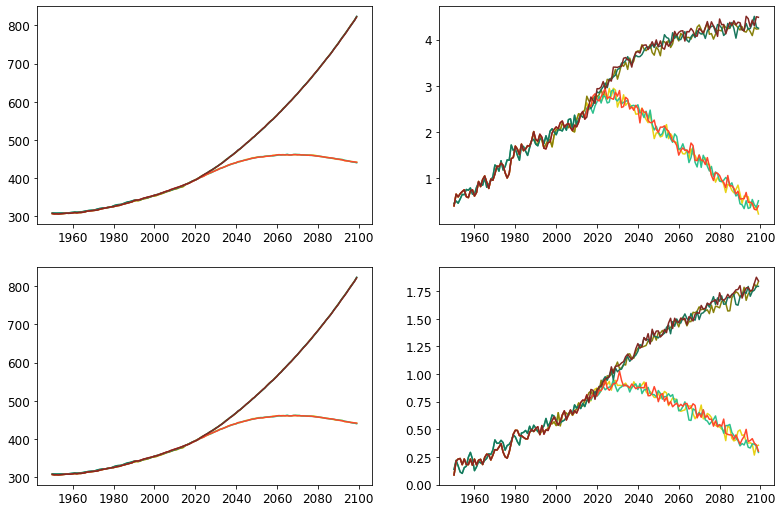

In [11]:
scens  = ['1A','1B','2A','2B','3A','3B']
PgC  = [PgC_1A,PgC_1B,PgC_2A,PgC_2B,PgC_3A,PgC_3B]
SOPgC  = [SOPgC_1A,SOPgC_1B,SOPgC_2A,SOPgC_2B,SOPgC_3A,SOPgC_3B]
pco2  = [pco2_1A,pco2_1B,pco2_2A,pco2_2B,pco2_3A,pco2_3B]
SOpco2  = [SOpco2_1A,SOpco2_1B,SOpco2_2A,SOpco2_2B,SOpco2_3A,SOpco2_3B]

for s in range(0,6):
    tcol = scendict[scens[s]]['color']
    scennam = scendict[scens[s]]['name']
    
yrs = np.arange(1950,2100)

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()
for s in range(0,6):
    tcol = scendict[scens[s]]['color']
    scennam = scendict[scens[s]]['name']
    axs[1].plot(yrs, PgC[s], color = tcol)
    axs[3].plot(yrs, SOPgC[s], color = tcol)
    axs[0].plot(yrs, pco2[s], color = tcol)
    axs[2].plot(yrs, SOpco2[s], color = tcol)

### plotting trend maps

In [ ]:
#select and groupby 

def plot_co(i, ind, tds, scen = '1A', var = 'CO2FLUX', tvmin = -10, tvmax = 10, latmax = 332 ):
    tchun = tds[var].sel(time_counter=tds[var].time_counter.dt.year.isin([np.arange(yrst[i],yren[i])])) #get chunk
    tchun_yrm = tchun.groupby('time_counter.year').mean('time_counter') #30 year mean
    tmean = np.nanmean(tchun_yrm, axis = 0)
    w = axs[ind].pcolormesh(tmean[0:latmax,:], vmin = tvmin, vmax = tvmax, cmap = cm.balance_r)
    axs[ind].set_xticks([]); axs[ind].set_yticks([])
    if ((i == 0)):
        cbar = plt.colorbar(w, ax = axs[ind], orientation='horizontal', aspect = 40)
        cbar.ax.tick_params(labelsize=8)
        tnam = scendict[scen]['name']
        tit = f'{tnam} {yrst[i]}-{yren[i]}'
        axs[ind].set_title(tit, fontsize = 11)
    else:
        tit = f'{yrst[i]}-{yren[i]}'
        axs[ind].set_title(tit, fontsize = 11)

In [ ]:
ds_1A = xr.open_mfdataset(dsl1A)
ds_1B = xr.open_mfdataset(dsl1B)
ds_2A = xr.open_mfdataset(dsl2A)
ds_2B = xr.open_mfdataset(dsl2B)
ds_3A = xr.open_mfdataset(dsl3A)
ds_3B = xr.open_mfdataset(dsl3B)

var = 'CO2FLUX'
yrst = [1950,1950,1980,2010,2040,2070]
yren = [1960,1980,2010,2040,2070,2100]
tvmax = 15
tvmin = -15

In [ ]:


fact = 1.4
fig, axs = plt.subplots(6,6, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tds = ds_1A; scen = '1A'; tnam = scendict[scen]['name']; 
for i in range(0,6):
    ind = i
    plot_co(i, ind, ds_1A, '1A', tvmax = tvmax, tvmin = tvmin)
for i in range(0,6):
    ind = i+6
    plot_co(i, ind, ds_2A, '2A', tvmax = tvmax, tvmin = tvmin)
for i in range(0,6):
    ind = i+12
    plot_co(i, ind, ds_3A, '3A', tvmax = tvmax, tvmin = tvmin)        
for i in range(0,6):
    ind = i+18
    plot_co(i, ind, ds_1B, '1B', tvmax = tvmax, tvmin = tvmin)
for i in range(0,6):
    ind = i+24
    plot_co(i, ind, ds_2B, '2B', tvmax = tvmax, tvmin = tvmin)
for i in range(0,6):
    ind = i+30
    plot_co(i, ind, ds_3B, '3B', tvmax = tvmax, tvmin = tvmin)
    
plt.tight_layout()

In [ ]:


fact = 1.4
fig, axs = plt.subplots(6,6, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

tds = ds_1A; scen = '1A'; tnam = scendict[scen]['name']; 
for i in range(0,6):
    ind = i
    plot_co(i, ind, ds_1A, '1A', tvmax = tvmax, tvmin = tvmin, latmax = 122)
for i in range(0,6):
    ind = i+6
    plot_co(i, ind, ds_2A, '2A', tvmax = tvmax, tvmin = tvmin, latmax = 122)
for i in range(0,6):
    ind = i+12
    plot_co(i, ind, ds_3A, '3A', tvmax = tvmax, tvmin = tvmin, latmax = 122)        
for i in range(0,6):
    ind = i+18
    plot_co(i, ind, ds_1B, '1B', tvmax = tvmax, tvmin = tvmin, latmax = 122)
for i in range(0,6):
    ind = i+24
    plot_co(i, ind, ds_2B, '2B', tvmax = tvmax, tvmin = tvmin, latmax = 122)
for i in range(0,6):
    ind = i+30
    plot_co(i, ind, ds_3B, '3B', tvmax = tvmax, tvmin = tvmin, latmax = 122)
    
plt.tight_layout()

In [ ]:
if test:
    scens = ['1A','1B','2A','2B','3A','3B']


    tscen = scens[5]
    print(tscen)
    y = 1991
    if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
        print('yes')
        tstr = scendict['1A']['hist_str']
    elif y<2015:
        tstr = scendict[tscen]['hist_str']

    else:
        tstr = scendict[tscen]['fut_str']

    print(tstr)

## cell for calculating means and averages

In [ ]:
extract = True

if extract:
    scens = ['1A','1B','2A','2B','3A','3B']

    for s in range(0,6):
        tscen = scens[s]
        fnam = f'./EXTRACT/medusa_{tscen}_CFLX_PCO2_1950-2100.nc'

        mean_OCN_PCO2 = np.zeros([150,12])
        mean_OCN_PCO2_SO = np.zeros([150,12])
        mean_CO2FLUX = np.zeros([150,12])
        mean_CO2FLUX_SO = np.zeros([150,12])


        for y in range(1950,2100):
            if ((y<1990) & ((tscen == '3A') | (tscen == '3B'))):
                tstr = scendict['1A']['hist_str']
            elif y<2015:
                tstr = scendict[tscen]['hist_str']

            else:
                tstr = scendict[tscen]['fut_str']

            try:
                td = glob.glob(f'/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa*{tstr}*{y}_diad-T*.nc')
                ds = xr.open_dataset(td[0])
                for m in range(1,13):
                    OCN_PCO2_mn, OCN_PCO2_SO_mn, CO2FLUX_mn, CO2FLUX_SO_mn = \
                    yr_month_cmeans_csums(m, ds, verbose = False)
                    mean_OCN_PCO2[y-1950,m-1] = OCN_PCO2_mn
                    mean_OCN_PCO2_SO[y-1950,m-1] = OCN_PCO2_SO_mn
                    mean_CO2FLUX[y-1950,m-1] = CO2FLUX_mn
                    mean_CO2FLUX_SO[y-1950,m-1] = CO2FLUX_SO_mn
                print(f'GOOD {tscen},{tstr}, {y}, {OCN_PCO2_mn}')
            except:
                print(f'FAIL {tscen},{tstr}, {y}')



        data_vars = {'mean_OCN_PCO2':(['year', 'month'], mean_OCN_PCO2,
                                 {'units': 'µatm',
                                  'long_name':'ocean pco2'}),
                     'mean_OCN_PCO2_SO':(['year', 'month'], mean_OCN_PCO2_SO,
                                 {'units': 'µatm',
                                  'long_name':'ocean pco2, south of -50'}),
                     'mean_CO2FLUX':(['year', 'month'], mean_CO2FLUX,
                                 {'units': 'mmol C /day',
                                  'long_name':'co2 flux'}),
                     'mean_CO2FLUX_SO':(['year', 'month'], mean_CO2FLUX_SO,
                                 {'units': 'mmol C /day',
                                  'long_name':'co2 flux'}),
                    }

        # define coordinates
        coords = {'year': (['year'], np.arange(1950,2100,1)),\
                 'month': (['month'], np.arange(1,13,1))}

        # define global attributes
        attrs = {'made in':'MEDUSA/MedusaCflxPco2.ipynb',
                }

        # create dataset
        ds = xr.Dataset(data_vars=data_vars,
                        coords=coords,
                        attrs=attrs)

        #fn = f'./examplenetcdf.nc'
        ds.to_netcdf(fnam)

In [ ]:
mmolC_to_PgC = 1e-18*12

In [ ]:
dim = np.array([31,28,31,30,31,30,31,31,30,31,30,31])

fact = 1.1
fig, axs = plt.subplots(2,2, figsize=(12*fact, 8*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

for s in range(0,6):
    tcol = scendict[scens[s]]['color']
    scennam = scendict[scens[s]]['name']
    tnam = f'./EXTRACT/medusa_{scens[s]}_CFLX_PCO2_1950-2100.nc'


    w = xr.open_dataset(tnam)
    #print(w)
    #print(np.shape(w['mean_OCN_PCO2'].values))
    t = w['mean_OCN_PCO2'].values
    t2 = w['mean_CO2FLUX'].values


    mean_OCN_PCO2_ts = np.zeros([150])
    mean_CO2FLUX_ts = np.zeros([150])
    mean_OCN_PCO2_SO_ts = np.zeros([150])
    mean_CO2FLUX_SO_ts = np.zeros([150])
    for i in range(0,150):
        mean_OCN_PCO2_ts[i] = np.ma.average(w['mean_OCN_PCO2'][i,:], weights=dim)
        mean_OCN_PCO2_SO_ts[i] = np.ma.average(w['mean_OCN_PCO2_SO'][i,:], weights=dim)
        mean_CO2FLUX_ts[i] = np.nansum(w['mean_CO2FLUX'][i,:] * dim)
        mean_CO2FLUX_SO_ts[i] = np.nansum(w['mean_CO2FLUX_SO'][i,:] * dim)

    axs[0].plot(np.arange(1950,2100), mean_OCN_PCO2_ts, color = tcol, label = scennam)
    axs[0].set_title('mean ocean pco2')
    axs[1].plot(np.arange(1950,2100), mean_CO2FLUX_ts * mmolC_to_PgC, color = tcol )
    axs[1].set_title('total co2 flux')
    axs[2].plot(np.arange(1950,2100), mean_OCN_PCO2_SO_ts, color = tcol )
    axs[2].set_title('mean ocean pco2, SO')
    axs[3].plot(np.arange(1950,2100), mean_CO2FLUX_SO_ts * mmolC_to_PgC, color = tcol )
    axs[3].set_title('total co2 flux, SO')

In [ ]:
w = xr.open_dataset('/gpfs/data/greenocean/software/resources/MEDUSA/PROCESSED/medusa_cj881_1y_2015_diad-T-subset.nc')
print(w)

#need area

In [ ]:
horse = False
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj200o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj200o'
    i = 0
    cj200o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            print(q[0])
            cj200o_co2flux[i,:,:] = tdat['CO2FLUX'][0,:,:]
            print(np.nansum(cj200o_co2flux[i,:,:]))
            i = i+1
    print(i)
    pickle.dump(cj200o_co2flux, open("medusa_cj200o_CO2FLUX_1990_2015.pkl", 'wb'))

# horse = True
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj198o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj198o'
    i = 0
    cj198o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            cj198o_co2flux[i,:,:] = tdat['CO2FLUX'][0,:,:]
            i = i+1
            print(i)
    print(i)
    pickle.dump(cj198o_co2flux, open("medusa_cj198o_CO2FLUX_1990_2015.pkl", 'wb'))

In [ ]:
horse = False
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj200o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj200o'
    i = 0
    cj200o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            print(q[0])
            cj200o_co2flux[i,:,:] = tdat['OCN_PCO2'][0,:,:]
            print(np.nansum(cj200o_co2flux[i,:,:]))
            i = i+1
    print(i)
    pickle.dump(cj200o_co2flux, open("medusa_cj200o_OCN_PCO2_1990_2015.pkl", 'wb'))

# horse = True
if horse:
    # w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj198o_1m_20130901-20131001_diad-T_SUBSET.nc')
    # print(w)

    rset = 'medusa_cj198o'
    i = 0
    cj198o_co2flux = np.zeros([300, 332, 362])
    for ty in range(1990,2015):
        for tm in range(1,13):
            if tm <10:
                ttm = f'0{tm}'
            else:
                ttm = tm

            ts = f'{ty}{ttm}'
            q = glob.glob(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/{rset}_1m_{ty}{ttm}01-*SUBSET.nc')
            tdat = xr.open_dataset(q[0])
            cj198o_co2flux[i,:,:] = tdat['OCN_PCO2'][0,:,:]
            i = i+1
            print(i)
    print(i)
    pickle.dump(cj198o_co2flux, open("medusa_cj198o_OCN_PCO2_1990_2015.pkl", 'wb'))

In [ ]:
#prasime_veci
dim = np.array([31,28,31,30,31,30,31,31,30,31,30,31])
mos = np.arange(1,13,1)
yrs = np.arange(1990,2015,1)
print(np.shape(yrs))

yrsrep = np.zeros(300)
mosrep = np.zeros(300)
dimrep = np.zeros(300)

for i in range(0,25):
    yrsrep[i*12:i*12+12] = 1990+i
    mosrep[i*12:i*12+12] = mos
    dimrep[i*12:i*12+12] = dim
    
# print(mosrep)


In [ ]:
cj200o_co2flux = pickle.load(open('medusa_cj200o_CO2FLUX_1990_2015.pkl', 'rb'))
cj198o_co2flux = pickle.load(open('medusa_cj198o_CO2FLUX_1990_2015.pkl', 'rb'))
cj200o_ocn_pco2 = pickle.load(open('medusa_cj200o_OCN_PCO2_1990_2015.pkl', 'rb'))
cj198o_ocn_pco2 = pickle.load(open('medusa_cj198o_OCN_PCO2_1990_2015.pkl', 'rb'))
print(np.shape(cj198o_ocn_pco2))

In [ ]:
yrslog = np.arange(1990,2015,1/12)
print(np.shape(yrslog))

In [ ]:
w = xr.open_dataset(f'/gpfs/home/mep22dku/scratch/MEDUSA/SUBSET/medusa_cj200o_1m_20130901-20131001_diad-T_SUBSET.nc')
tar = (w['area'].values)
nav_lat = (w['nav_lat'])
print(w.area)
print(w.CO2FLUX)
## 113 is the nav lat boundary



In [ ]:
   BAC                   (time_counter, deptht, y, x) float32 ...
    PRO                   (time_counter, deptht, y, x) float32 ...
    PTE                   (time_counter, deptht, y, x) float32 ...
    MES                   (time_counter, deptht, y, x) float32 ...
    GEL                   (time_counter, deptht, y, x) float32 ...
    MAC                   (time_counter, deptht, y, x) float32 ...
    DIA                   (time_counter, deptht, y, x) float32 ...
    MIX                   (time_counter, deptht, y, x) float32 ...
    COC                   (time_counter, deptht, y, x) float32 ...
    PIC                   (time_counter, deptht, y, x) float32 ...
    PHA                   (time_counter, deptht, y, x) float32 ...
    FIX                   (time_counter, deptht, y, x) float32 ...

In [ ]:
names = ['BAC','PRO','PTE','MES','GEL','MAC','DIA','MIX','COC','PIC','PHA','FIX']
w = xr.open_dataset('/gpfs/data/greenocean/software/runs/TOM12_RW_3G76/ORCA2_1m_20210101_20211231_ptrc_T.nc')
for i in range(0, len(names)):
    print(w[names[i]])

In [ ]:
siy = 60*60*24*365
pg_in_mol = 12 * 1e-15
pg_in_mmol = 12 * 1e-18
diy = 365


Acj198o_co2flux_so = np.zeros([300])
Acj198o_co2flux = np.zeros([300])
Acj200o_co2flux_so = np.zeros([300])
Acj200o_co2flux = np.zeros([300])

for i in range(0,300):
    Acj198o_co2flux_so[i] = np.nansum(cj198o_co2flux[i,0:113,:] * tar[0:113,:])* pg_in_mmol * dimrep[i]
    Acj198o_co2flux[i] = np.nansum(cj198o_co2flux[i,:,:] * tar[:,:])* pg_in_mmol * dimrep[i]
    Acj200o_co2flux_so[i] = np.nansum(cj200o_co2flux[i,0:113,:] * tar[0:113,:])* pg_in_mmol * dimrep[i]
    Acj200o_co2flux[i] = np.nansum(cj200o_co2flux[i,:,:] * tar[:,:]) * pg_in_mmol * dimrep[i]

## per month

In [ ]:

fact = 2
fig, axs = plt.subplots(2,1, figsize=(4.8*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(yrslog,Acj200o_co2flux, label = 'forever ozone hole (yr 1990 forever)')
axs[0].plot(yrslog,Acj198o_co2flux, label = 'no ozone hole')
axs[1].plot(yrslog,Acj200o_co2flux_so, label = 'forever ozone hole (yr 1990 forever)')
axs[1].plot(yrslog,Acj198o_co2flux_so, label = 'no ozone hole')

axs[0].legend()

for i in range(0,2):
    axs[i].grid()
    axs[i].set_xlim([1990,2015])
plt.suptitle('monthly carbon uptake (pG CO2)) in UKESM1-MEDUSA \n 2 ozone scenarios 1990-2015 \n top plot global, bottom SO')

In [ ]:
Ycj198o_co2flux_so = np.zeros([25])
Ycj198o_co2flux = np.zeros([25])
Ycj200o_co2flux_so = np.zeros([25])
Ycj200o_co2flux = np.zeros([25])

for y in range(1990,2015):
    Ycj200o_co2flux[y-1990] = np.nansum(Acj200o_co2flux[yrsrep ==y])
    Ycj200o_co2flux_so[y-1990] = np.nansum(Acj200o_co2flux_so[yrsrep ==y])
    Ycj198o_co2flux[y-1990] = np.nansum(Acj198o_co2flux[yrsrep ==y])
    Ycj198o_co2flux_so[y-1990] = np.nansum(Acj198o_co2flux_so[yrsrep ==y])    
# plt.plot(Ycj200o_co2flux)

In [ ]:

fact = 2
fig, axs = plt.subplots(2,1, figsize=(4.8*fact, 5*fact), facecolor='w', edgecolor='k')
axs = axs.ravel()

axs[0].plot(np.arange(1990,2015,1),Ycj200o_co2flux, color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[0].plot(np.arange(1990,2015,1),Ycj198o_co2flux, color = 'k', label = 'no ozone hole')
axs[1].plot(np.arange(1990,2015,1),Ycj200o_co2flux_so, color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[1].plot(np.arange(1990,2015,1),Ycj198o_co2flux_so, color = 'k', label = 'no ozone hole')
axs[0].plot(2002.5,np.nanmean(Ycj200o_co2flux), marker = 'o', color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[0].plot(2002.5,np.nanmean(Ycj198o_co2flux), marker = 'o', color = 'k', label = 'no ozone hole')
axs[1].plot(2002.5,np.nanmean(Ycj200o_co2flux_so), marker = 'o', color = 'r', label = 'forever ozone hole (yr 1990 forever)')
axs[1].plot(2002.5,np.nanmean(Ycj198o_co2flux_so), marker = 'o', color = 'k', label = 'no ozone hole')

axs[0].legend()

for i in range(0,2):
    axs[i].grid()
    axs[i].set_xlim([1990,2015])
plt.suptitle('yearly carbon uptake (pG CO2)) in UKESM1-MEDUSA \n 2 ozone scenarios 1990-2015 \n (bottom plot is SO)')